In [1]:
import csv
import sys
import os
import pickle
import random
import numpy as np
import time
import operator
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt

from collections import Counter

import statsmodels.stats.api as sms

import scipy.stats
from scipy.stats import entropy
from scipy.stats import spearmanr
from scipy.stats import zscore
from sklearn.linear_model import LinearRegression
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
np.set_printoptions(precision=2)

In [3]:
sys.path.append('../python')
from permutation import permutation, compute_alignment_strength
from utils.utils_funcs import aggregate_embeddings_visual_and_language, get_variance, get_distinctness_from_nearest_5
from utils.utils_funcs import load_data_to_dict

In [4]:
def get_alignment_strength(struct,concepts,relative):
    visual_embeddings_list=list()
    langauge_embeddings_list=list()
    for concept in concepts:
        embeddings=struct["embeds"][concept]
        visual_embeddings_list.append(embeddings["visual"])
        langauge_embeddings_list.append(embeddings["language"])
    z_0=np.array(visual_embeddings_list)
    z_1=np.array(langauge_embeddings_list)
    if relative:
        return permutation(z_0,z_1,n_sim=100)[0]
    else:
        return compute_alignment_strength(z_0,z_1)

In [5]:
imagenet_data=pickle.load(open("../data/dumped_embeddings/imagenet_concept_swav_bert_20.pkl","rb"))

In [6]:
aggregated_imagenet_data=aggregate_embeddings_visual_and_language(imagenet_data,1,1)

In [7]:
# kuperman aoa
noun_aoa_dict=dict()
with open("../data/processed/AoA_Kuperman.csv","r") as f:
    next(f)
    for row in f:
        temp=row.replace('\n','').replace('\r','').split(",")
        if temp[0]:
            if temp[0] in imagenet_data["words"]:
                noun_aoa_dict[temp[0]]=float(temp[4])
noun_aoa_sorted= sorted(noun_aoa_dict.items(), key=operator.itemgetter(1))

In [8]:
# noun_aoa_dict=load_data_to_dict("../data/processed/aoa/wordbank_noun_aoa.txt",concepts=vg_noun_data["words"])
# verb_aoa_dict=load_data_to_dict("../data/processed/aoa/wordbank_verb_aoa.txt",concepts=vg_verb_data["words"])

# noun_aoa_sorted = sorted(noun_aoa_dict.items(), key=operator.itemgetter(1))
# verb_aoa_sorted = sorted(verb_aoa_dict.items(), key=operator.itemgetter(1))

In [9]:
# noun_aoa_dict=load_data_to_dict("../data/processed/aoa/glasgow_noun_aoa.txt",concepts=vg_noun_data["words"])
# verb_aoa_dict=load_data_to_dict("../data/processed/aoa/glasgow_verb_aoa.txt",concepts=vg_verb_data["words"])

# noun_aoa_sorted = sorted(noun_aoa_dict.items(), key=operator.itemgetter(1))
# verb_aoa_sorted = sorted(verb_aoa_dict.items(), key=operator.itemgetter(1))

In [10]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h

In [11]:
def compute_alignment(concepts,shuffled_concepts,struct,relative):
    num_list=list()
    for sh_concepts in shuffled_concepts:
        num_list.append(get_alignment_strength(struct,sh_concepts,relative))
    temp=mean_confidence_interval(num_list)
    return get_alignment_strength(struct,concepts,relative),temp[0],temp[1]

In [12]:
def sim_in_order(struct,concepts,step=20,num_simulation=1000,concept_accum=True,relative=False):
    
    xs=list()
    ag_true=list()
    ag_sh=list()
    ag_sh_err=list()

    for idx in range(0,len(concepts),step):
        if concept_accum:
            concept_group=concepts[:idx+step]
        else:
            concept_group=concepts[idx:idx+step]
        
        shuffled_list=list()
        temp=concepts.copy()
        for i in range(num_simulation):
            random.shuffle(temp)
            temp2=temp[:len(concept_group)]
            shuffled_list.append(temp2)
            # print(sorted(temp2))
            # for j in temp2:
            #     if j not in concept_group:
            #         print(j)
        
        xs.append(min(idx+step,len(concepts)))
        ag_rts=compute_alignment(concept_group,shuffled_list,struct,relative)
        ag_true.append(ag_rts[0])
        ag_sh.append(ag_rts[1])
        ag_sh_err.append(ag_rts[2])
    
    return ag_true,ag_sh,ag_sh_err,xs

In [13]:
def sim_in_order(struct,concepts,step=20,num_simulation=1000,concept_accum=True,relative=False):
    
    xs=list()
    ag_true=list()
    ag_sh=list()
    ag_sh_err=list()
    
    for idx in range(0,len(concepts),step):
        if concept_accum:
            concept_group=concepts[:idx+step]
        else:
            concept_group=concepts[idx:idx+step]
        xs.append(min(idx+step,len(concepts)))
        ag_true.append(get_alignment_strength(struct,concept_group,relative))
    
    temp=concepts.copy()
    ll=list()
    for i in range(num_simulation):
        random.shuffle(temp)
        l=list()
        for idx in range(0,len(temp),step):
            if concept_accum:
                concept_group=temp[:idx+step]
            else:
                concept_group=temp[idx:idx+step]
            l.append(get_alignment_strength(struct,concept_group,relative))
        ll.append(l)
    ll=np.array(ll)
    for i in range(ll.shape[1]):
        temp=mean_confidence_interval([row[i] for row in ll])
        ag_sh.append(temp[0])
        ag_sh_err.append(temp[1])
        
    return ag_true,ag_sh,ag_sh_err,xs

In [14]:
def plot_percentage_in_order(title,struct,concepts,step=20,num_simulation=1000,concept_accum=True,relative=False):
    t1=time.time()
    ag_true,ag_sh,ag_sh_err,xs=sim_in_order(struct,concepts,step,num_simulation,concept_accum,relative)
    t2=time.time()
    print(t2-t1)
    
    plt.plot(xs,ag_true,color="green",label="Alignment Strength of True Order")
    #plt.plot(xs,ag_sh,color="red",label="Alignment Strength of Random Concepts")
    plt.errorbar(xs,ag_sh,yerr =ag_sh_err,color="red",label="Alignment Strength of Random Concepts")
    plt.title(title)
    plt.xlabel("number of concepts in the system")
    plt.ylabel("Alignment Strength")
    plt.legend() 
    
    print(xs)
    print("alignment true:",ag_true)
    print("alignment shuffled:",ag_sh)

46.16199588775635
[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 425]
alignment true: [0.009486166007905137, 0.0905063706386385, 0.07865926462634323, 0.02375632286858308, 0.03038499576013113, 0.03797849309883513, 0.05294908115040747, 0.07370002535021254, 0.10199655421989967, 0.11376744289741733, 0.11033366428768263, 0.1099054892156646, 0.08683710596509288, 0.07724758625565821, 0.06536114870138167, 0.06676951909189924, 0.0767700800539565, 0.07251997625157329, 0.07152596939185338, 0.06735778713692335, 0.066555565400052, 0.06892481208473292, 0.06458615454639931, 0.07009799512978247, 0.06680746337484966, 0.06515468578142249, 0.06657395539655991, 0.06748721561753875, 0.06621040579090229, 0.06649284528751939, 0.06525072863772764, 0.06713306201297116, 0.06328966689112486, 0.06429754111050384, 0.06717940000340034, 0.06645766908029298, 0.0664

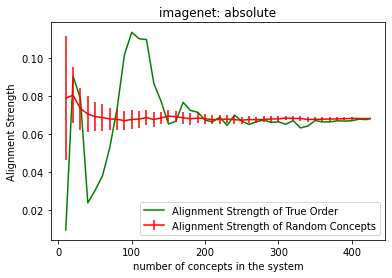

In [15]:
plot_percentage_in_order("imagenet: absolute",aggregated_imagenet_data,list(list(zip(*noun_aoa_sorted))[0]),
                         step=10,num_simulation=100,concept_accum=True,relative=False)

432.4299759864807
[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 425]
alignment true: [0.48, 0.78, 0.91, 0.71, 0.78, 0.93, 0.89, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
alignment shuffled: [0.6119999999999999, 0.7130000000000001, 0.7390000000000001, 0.9039999999999999, 0.9120000000000001, 0.976, 0.9700000000000001, 0.9799999999999999, 0.984, 0.9819999999999999, 0.9870000000000001, 0.9960000000000001, 0.999, 0.998, 0.9949999999999999, 0.998, 0.9970000000000001, 0.9969999999999999, 0.999, 0.999, 1.0, 1.0, 1.0, 1.0, 0.999, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


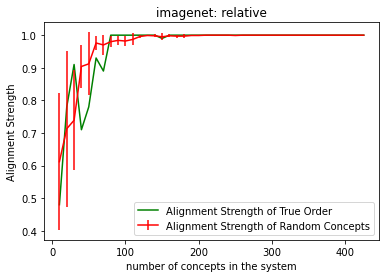

In [16]:
plot_percentage_in_order("imagenet: relative",aggregated_imagenet_data,list(list(zip(*noun_aoa_sorted))[0]),
                         step=10,num_simulation=10,concept_accum=True,relative=True)